# Loading potentials tutorial

This tutorial will show you how to use the potential module to load pre-processed potential files. It creates a PotentialInterpolator object which allows us to find the potential landscape at arbitrary control voltage values.

## 1. Load the relevant modules

The file nextnano_3D takes in a folder of pre-processed potential files. These files have to follow the naming convention 'TYPE_C1NAME_C1VAL_C2NAME_C2VAL_..._CNNAME_CNVAL.txt' where TYPE = 'Uxy' or 'Ez'.  The C#NAME indicates the name for the control voltages and C#VAL indicates the corresponding control voltage value. The TYPE flag indicates whether you are loading potentials or electric field files.

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import qudipy as qd
import qudipy.potential as pot

import numpy as np
import matplotlib.pyplot as plt

## 2. Define which files to load and load them

We need to specify the name of the folder that contains the potential files as well as the names for each potential file.

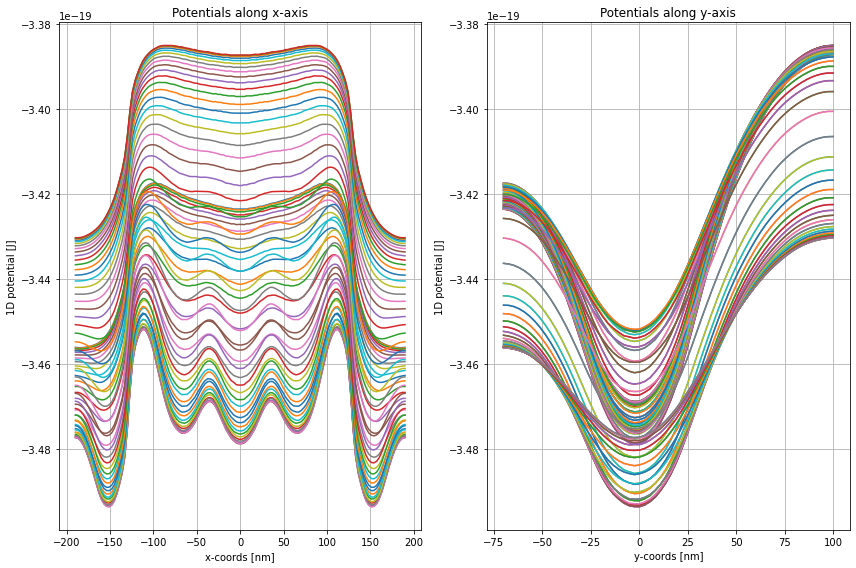

In [2]:
# Enter the name of the folder where the potential files are located. 
# If this argument is not supplied it will assume the current working directory.
# pot_dir = os.path.dirname(os.getcwd()) + '/tutorials/QuDiPy tutorial data/Pre-processed potentials/Unkown_slice/'
pot_dir = os.path.dirname(os.getcwd()) + '/tutorials/QuDiPy tutorial data/Pre-processed potentials/Unkown_slice/'

# Specify the control voltage names (C#NAME as mentioned above)
ctrl_names = ['V1','V2','V3','V4','V5']

# Specify the control voltage values you wish to load.
# The cartesian product of all these supplied voltages will be loaded and MUST exist in the directory.

# General gate voltage definition to be used for potential files in Uknown_slice directory
V1 = [0.1]
V2 = [0.2, 0.22, 0.24, 0.26]
V3 = [0.2, 0.22, 0.24, 0.26, 0.28]
V4 = [0.2, 0.22, 0.24, 0.26, 0.28, 0.30]
V5 = [0.1]

# Add all voltage values to a list
ctrl_vals = [V1, V2, V3, V4, V5]    
# Now load the potentials.  
# load_files returns a dictionary of all the information loaded
# f_type says we are loading potential files (other option is to load electric field files)
# f_dir specifies where the files are located
# f_dis_units specifies the distance units the files are in. The function will convert the units to [m].
# f_pot_units specifies the potential units the files are in. The function will convert the units to [J].
loaded_data = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='pot', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='eV')
# Additional keyword arguments are trim_x and trim_y which will trim the loaded potentials 
# to be only within the bounds specified by trim_x and trim_y

# We can check the fields of the dictionary returned to see what is stored.
loaded_data.keys()

# We can also go on to plot all of potential crossections along the x/y-planes for the choosen slice.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# potential along x-axis at y-axis slice
for i in range(np.shape(loaded_data['coords'][1])[0]):
    ax1.plot(loaded_data['coords'][0].T/1E-9,loaded_data['potentials'][0][i,:].T)
ax1.set(xlabel='x-coords [nm]', ylabel='1D potential [J]',
title=f'Potentials along x-axis')  
ax1.grid()  

# potential along y-axis at x-axis slice
test = loaded_data['potentials'][0][:].T
for i in range(np.shape(loaded_data['coords'][0])[0]):
    ax2.plot(loaded_data['coords'][1]/1E-9,loaded_data['potentials'][0][:,i])
ax2.set(xlabel='y-coords [nm]', ylabel='1D potential [J]',
title=f'Potentials along y-axis')
ax2.grid()

fig.tight_layout()       
plt.show()

## 3. Store x and y coordinates in a GridParameters object

In [3]:
# It's a bit convoluted, but the x and y coordinates are
# stored as a named tuple in the dictionary returned from load_files.
# With those values, we will build a GridParameters object.
coord = loaded_data['coords']
x = coord.x
y = coord.y

# Construct a GridParameters object
gparams = pot.GridParameters(x,y)
coord.x

array([-1.90000000e-07, -1.87007874e-07, -1.84015748e-07, -1.81023622e-07,
       -1.78031496e-07, -1.75039370e-07, -1.72047244e-07, -1.69055118e-07,
       -1.66062992e-07, -1.63070866e-07, -1.60078740e-07, -1.57086614e-07,
       -1.54094488e-07, -1.51102362e-07, -1.48110236e-07, -1.45118110e-07,
       -1.42125984e-07, -1.39133858e-07, -1.36141732e-07, -1.33149606e-07,
       -1.30157480e-07, -1.27165354e-07, -1.24173228e-07, -1.21181102e-07,
       -1.18188976e-07, -1.15196850e-07, -1.12204724e-07, -1.09212598e-07,
       -1.06220472e-07, -1.03228346e-07, -1.00236220e-07, -9.72440945e-08,
       -9.42519685e-08, -9.12598425e-08, -8.82677165e-08, -8.52755906e-08,
       -8.22834646e-08, -7.92913386e-08, -7.62992126e-08, -7.33070866e-08,
       -7.03149606e-08, -6.73228346e-08, -6.43307087e-08, -6.13385827e-08,
       -5.83464567e-08, -5.53543307e-08, -5.23622047e-08, -4.93700787e-08,
       -4.63779528e-08, -4.33858268e-08, -4.03937008e-08, -3.74015748e-08,
       -3.44094488e-08, -

## 4. Build the PotentialInterpolator object

In [4]:
# Now building the interpolation object is trivial.
# When building the interpolator, we should pass also a Constants object
# which indicates the material system for the potentials.
pot_interp = pot.build_interpolator(loaded_data, constants=qd.Constants("Si/SiO2"))

# Right now, the interpolator will interpolate 2D potentials. However, this may be 
# costly for things that do lots of interpolations but you are only interested in 
# 1D potentials. You can make a 1D interpolator object by specifying the y_slice 
# keyword argument.
# pot_interp = pot.build_interpolator(loaded_data, constants=qd.Constants("Si/SiO2"),
#                                     y_slice=0)

pot_interp

## 5. Do some potential interpolation (with lots of plotting examples)
Now let's show how we can actually use this object to do interpolation.

In [5]:
# Define a voltage vector you wish to interpolate the potential at
v_vec = [0.1, 0.2, 0.23, 0.2, 0.1]
# As a note.. You can also ignore the singleton dimensions we defining the voltage vector
# i.e. v_vec = [0.2, 0.23, 0.2]
pot_interp(v_vec)

0.2
[0.2, 0.23, 0.2]


TypeError: object of type 'numpy.float64' has no len()

You can see what is returned is the 2D potential landscape of the device in meshgrid format (y,x). The PotentialInterpolator object has a nice plot method we can use to see how the interpolated potentials look and that everything makes sense.

In [ ]:
# First we will do an interpolation and look at the 2D potential
# Notice how I am only using 3 voltage values now when I interpolate
# instead of 5 as I was earlier.
v_vec = [0.2]
# Plot the 2D potential
pot_interp.plot(v_vec)
# Now I will show you how you can view just 1D slices of the potential.
# Get a 1D slice of the potential along y=0 axis.
pot_interp.plot(v_vec,plot_type='1D')
# Get a 1D slice of the potential along y=10 nm axis
pot_interp.plot(v_vec, plot_type='1D',y_slice=10E-9)
# Get a 1D slice of the potential along y=65 nm axis and a 1D slice along x=0 nm axis
pot_interp.plot(v_vec, plot_type='1D',y_slice=65E-9,x_slice=0)
# Get a 1D slice of the potential along y=0 nm axis and a 1D slice along x=60 nm axis.
pot_interp.plot(v_vec, plot_type='1D',x_slice=60E-9)

# .plot() also has show_wf and wf_n flags which will display the nth wavefunction with the potential
# Plot the 2D potential and show the ground state wf
pot_interp.plot(v_vec, show_wf=True) # pot_interp.plot(v_vec, show_wf=True, wf_n=0) would plot the same thing
# Get a 1D slice of the potential along y=0 nm axis and a 1D slice along x=0 nm axis.
# Overlay the 3rd excited wavefunction (4th lowest energy state)
pot_interp.plot(v_vec, plot_type='1D',x_slice=0, show_wf=True, wf_n=0)
pot_interp.plot(v_vec, plot_type='1D',x_slice=0, show_wf=True, wf_n=3)

These potentials look like what we expect from the nextnano simulations.  Let's do a few more plots though of the potential at different gate voltages to check that the interpolator actually varies the potential correctly.

In [ ]:
# Let's do 4 different interpolations
v_vec1 = [0.2]
v_vec2 = [0.23]
v_vec3 = [0.24]
v_vec4 = [0.25]

pot_interp.plot(v_vec1,plot_type='1D')
pot_interp.plot(v_vec2,plot_type='1D')
pot_interp.plot(v_vec3,plot_type='1D')
pot_interp.plot(v_vec4,plot_type='1D')

The potentials are changing exactly as we would expect. Great!

As a last note before concluding the tutorial, notice that if we call voltage values outside of the range of values we loaded, the interpolator object will throw an error.

In [ ]:
#v_vec = [0.1, 0.26, 0.29, 0.3, 0.1] # .29 is out range
#pot_interp(v_vec)

## 6. Creating Analytical potentials

Sometimes we would like to create an analytical potential (e.g. for testing purposes). You can create this by using the `analytical_potential` function.  

To create such a potential, perform the following steps:

1. Create the control names and control values as we would for a potential generated by nextnano. 
2. Define a function that maps out the potential in space for given values of the control variables. The potential defining function must take exactly two variables: control variable values and a GridParameters object.
3. Specify the `x` and `y` values that will create our grid points for the potential.
4. Pass the control values, the control names, the potential defining fucntion and the x and y values to the `analytical_potential` function. This function will return an analytical potential that can be used an input for the `build_interpolator` function. 
5. Pass the output of the `analytical_potential` function to the `build_interpolator` function. This potential interpolator then behaves in the same way as described earlier in the tutorial.

For an example of an analytical potential being generated and used, see below.

In [ ]:
# 1. Create control voltage names and variables the same way you would normally do
ctrl_names = ['V1','V2']

V1 = [0.2, 0.22, 0.24, 0.26]
V2 = [0.2, 0.22, 0.24, 0.26, 0.28]

ctrl_vals = [V1, V2]

# 2. Create the function which defines the potential, with the control variables as the 
# first argument and a GridParameters object as the second argument

# Specify some constants for the potential
dot_sep = 150e-9
consts=qd.Constants("Si/SiO2")
def create_potentials(cvals, gparams):
    # Get coordinates from mesh
    x_pot = gparams.x_mesh
    y_pot = gparams.y_mesh

    # Get voltages out from the control valriables
    v_1 = cvals[0]
    v_2 = cvals[1]

    # Convert (linear conversion) from voltages to chemical potentials
    # This is just a linear relationship with a dummy lever arm
    lever_arm_1 = 1
    mu_1 = v_1 * lever_arm_1 * consts.e
    lever_arm_2 = 1
    mu_2 = v_2 * lever_arm_2 * consts.e

    # Define frequency of harmonic oscillators
    omega_1 = 5e12
    omega_2 = 5e12

    # Define the potential
    well_1 = 1/2 * consts.me * omega_1**2 * (np.square(x_pot + dot_sep) + np.square(y_pot)) - mu_1
    well_2 = 1/2 * consts.me * omega_2**2 * (np.square(x_pot - dot_sep) + np.square(y_pot)) - mu_2
    potential = np.minimum(well_1, well_2)
    return potential

# 3. Specify the x and y points you would like to have in a grid
x = np.arange(-2 * dot_sep, 2 * dot_sep, dot_sep/30)
y = np.arange(-2 * dot_sep, 2 * dot_sep, dot_sep/30)

# 4. Get the analytical potential using 
analytic_potential = pot.analytical_potential(ctrl_vals, ctrl_names, create_potentials, x, y)

# 5. Pass analytical_potential to build_interpolator
# This behaves exactly like any other potential interpolator
an_pot_interp = pot.build_interpolator(analytic_potential, constants=qd.Constants("Si/SiO2"))

# Now specify the potentials to interpolate around
v_vec = [0.23, 0.25]

# Plot the 2D potential
an_pot_interp.plot(v_vec)

# Plot various 1D slices, one with a ground state wavefunction probability
an_pot_interp.plot(v_vec, plot_type='1D', y_slice=0, show_wf=True)

# When we swap the gate voltages and plot the wavefunction, we can see that it has the intended effect of 
# moving the location of the ground state of the electron wavefunction
v_vec = [0.25, 0.23]
an_pot_interp.plot(v_vec, plot_type='1D', y_slice=0, show_wf=True)
